In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier  
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV


## 1. Revisión del dataset

In [3]:
df = pd.read_csv('../data/raw/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
nulos = df.isnull().sum()

columnas_con_nulos = nulos[nulos > 0]

if columnas_con_nulos.empty:
    print("sin nulos")
else:
    print(columnas_con_nulos)

sin nulos


In [6]:
target = df['HeartDisease'].value_counts()
print("Conteo de valores para la columna 'HeartDisease':")
print(target.sort_index())

Conteo de valores para la columna 'HeartDisease':
HeartDisease
0    410
1    508
Name: count, dtype: int64


In [21]:
import os
ruta_guardado = '../reports/figures/'
os.makedirs(os.path.dirname(ruta_guardado), exist_ok=True)

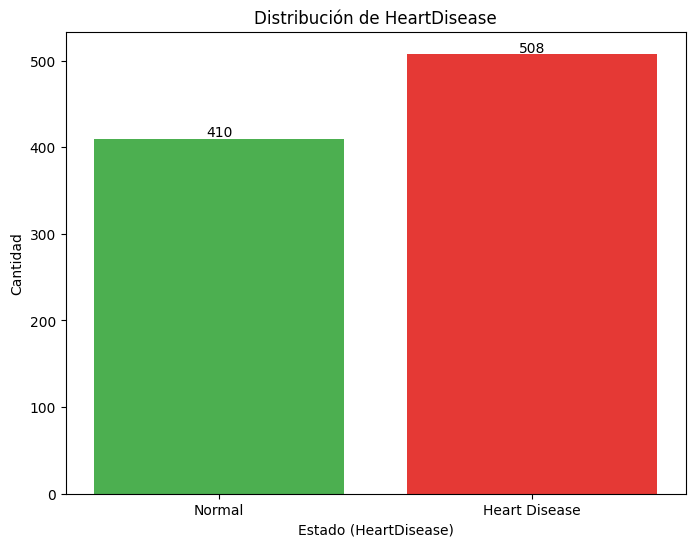

In [23]:
target = df['HeartDisease'].value_counts().sort_index()
labels = {0: 'Normal', 1: 'Heart Disease'}
x = target.index.astype(int)
x_labels = [labels[i] for i in x]

plt.figure(figsize=(8,6))
plt.bar(x, target.values, color=['#4CAF50', '#E53935'])
plt.xticks(x, x_labels)          
plt.xlabel('Estado (HeartDisease)')
plt.ylabel('Cantidad')
plt.title('Distribución de HeartDisease')

# Anotar valores
for i, v in enumerate(target.values):
    plt.text(x[i], v + 2, str(v), ha='center')

plt.savefig(ruta_guardado + 'distribution_heartdisease.png', dpi=1000, bbox_inches='tight') 

plt.show()

## 2. Separar y Escalar Datos

In [8]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('HeartDisease')
categorical_cols = df.select_dtypes(include=['object']).columns

target = df['HeartDisease']
numeric_features = df[numeric_cols]
categorical_feats = df[categorical_cols]

categorical_encoded = pd.get_dummies(categorical_feats, drop_first=True)
features = pd.concat([numeric_features, categorical_encoded], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=42,
    stratify=target
)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

X_train_scaled

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
485,0.970012,0.339016,0.127137,1.835497,-0.324520,0.317046,True,True,False,False,False,True,True,True,False
486,0.122028,-1.266031,0.099443,1.835497,1.689837,-0.440356,True,True,False,False,False,True,False,False,True
117,0.546020,-0.159102,1.244113,1.835497,-0.247045,0.601071,False,False,False,False,False,True,True,True,False
361,-0.725956,1.501291,-1.876035,-0.544812,-0.479470,-0.819056,True,False,False,False,True,False,True,True,False
296,-0.407962,0.671094,-1.876035,1.835497,0.101594,-0.156330,True,False,False,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,-0.301964,0.117630,-0.399042,-0.544812,0.527708,1.074447,True,False,True,False,True,False,False,True,False
201,-0.831954,-0.712567,0.247142,-0.544812,0.527708,-0.819056,True,False,True,False,True,False,False,False,True
462,0.546020,-0.601874,0.274836,-0.544812,-0.750634,0.411721,True,False,False,False,True,False,True,False,False
252,0.758016,-0.435834,0.819477,-0.544812,-0.828109,-0.819056,True,False,False,False,False,True,True,False,True


## 3. Modelado y Evaluación 

In [9]:
# Diccionario para guardar resultados de los diferentes modelos
model_scores = {}

In [ ]:
'''Entrenamiento con Random Forest'''
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
model_scores['Random Forest'] = accuracy_rf

print(f"Accuracy: {accuracy_rf:.3f}")
print(f"\nF1: {f1_score(y_test, y_pred_rf):.3f}")
print(classification_report(y_test, y_pred_rf, digits=3))

Accuracy: 0.875
F1: 0.888
              precision    recall  f1-score   support

           0      0.864     0.854     0.859        82
           1      0.883     0.892     0.888       102

    accuracy                          0.875       184
   macro avg      0.874     0.873     0.873       184
weighted avg      0.875     0.875     0.875       184



In [11]:
'''Entrenamiento Regresión Logística'''
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

accuracy_rl = accuracy_score(y_test, y_pred_lr)
model_scores['Regresión Logística'] = accuracy_rl

print(f"Accuracy: {accuracy_rl:.3f}")
print(f"\nF1: {f1_score(y_test, y_pred_lr):.3f}")
print(classification_report(y_test, y_pred_lr, digits=3))

Accuracy: 0.886

F1: 0.900
              precision    recall  f1-score   support

           0      0.907     0.829     0.866        82
           1      0.872     0.931     0.900       102

    accuracy                          0.886       184
   macro avg      0.889     0.880     0.883       184
weighted avg      0.887     0.886     0.885       184



In [14]:
'''Entrenamiento con XGBoost'''
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss"
)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
model_scores['XGBoost'] = accuracy_xgb

print(f"Accuracy: {accuracy_xgb:.3f}")
print(f"\nF1: {f1_score(y_test, y_pred_xgb):.3f}")
print(classification_report(y_test, y_pred_xgb, digits=3))

Accuracy: 0.864

F1: 0.876
              precision    recall  f1-score   support

           0      0.835     0.866     0.850        82
           1      0.889     0.863     0.876       102

    accuracy                          0.864       184
   macro avg      0.862     0.864     0.863       184
weighted avg      0.865     0.864     0.864       184



In [13]:
'''Entrenamiento con SVM'''
svm_rbf = SVC(kernel="rbf", probability=True, random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
y_pred_svm = svm_rbf.predict(X_test_scaled)

accuracy_svc = accuracy_score(y_test, y_pred_svm)
model_scores['SVC'] = accuracy_svc

print(f"Accuracy: {accuracy_svc:.3f}")
print(f"\nF1: {f1_score(y_test, y_pred_svm):.3f}")
print(classification_report(y_test, y_pred_svm, digits=3))

Accuracy: 0.886

F1: 0.899
              precision    recall  f1-score   support

           0      0.886     0.854     0.870        82
           1      0.886     0.912     0.899       102

    accuracy                          0.886       184
   macro avg      0.886     0.883     0.884       184
weighted avg      0.886     0.886     0.886       184



## 4. Gráficas


Ranking de los modelos por 'accuracy':
                     Accuracy
Regresión Logística   0.88587
SVC                   0.88587
Random Forest         0.87500
XGBoost               0.86413


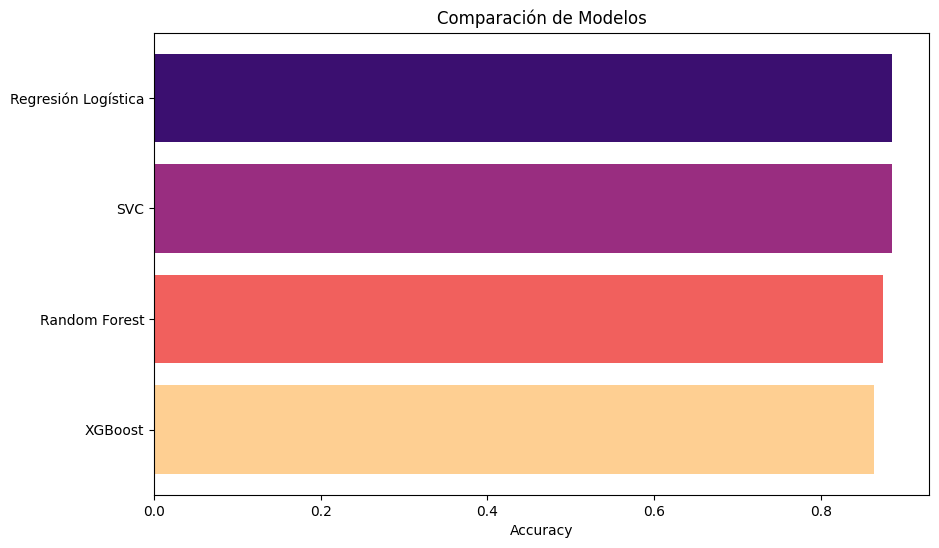

In [24]:
# Mostramos los mejores modelos
# Para ello, nos basamos principalmente en la metrica de 'accuracy
# Ya que nos interesa cuál es el porcentaje de las predicciones correctas
# considerando que el dataset no esta tan desbalanceado. 

scores_df = pd.DataFrame.from_dict(model_scores, orient='index', columns=['Accuracy'])
scores_df_sorted = scores_df.sort_values(by='Accuracy', ascending=False)

print("Ranking de los modelos por 'accuracy':")
print(scores_df_sorted)

n_models = len(scores_df_sorted)
cmap = plt.get_cmap('magma')
colors = cmap(np.linspace(0.2, 0.9, n_models))

plt.figure(figsize=(10, 6))
plt.barh(scores_df_sorted.index, scores_df_sorted['Accuracy'], color=colors)
plt.xlabel('Accuracy')
plt.title('Comparación de Modelos')
plt.gca().invert_yaxis() 
plt.savefig(ruta_guardado + 'ranking_modelos.png', dpi=1000, bbox_inches='tight') 
plt.show()

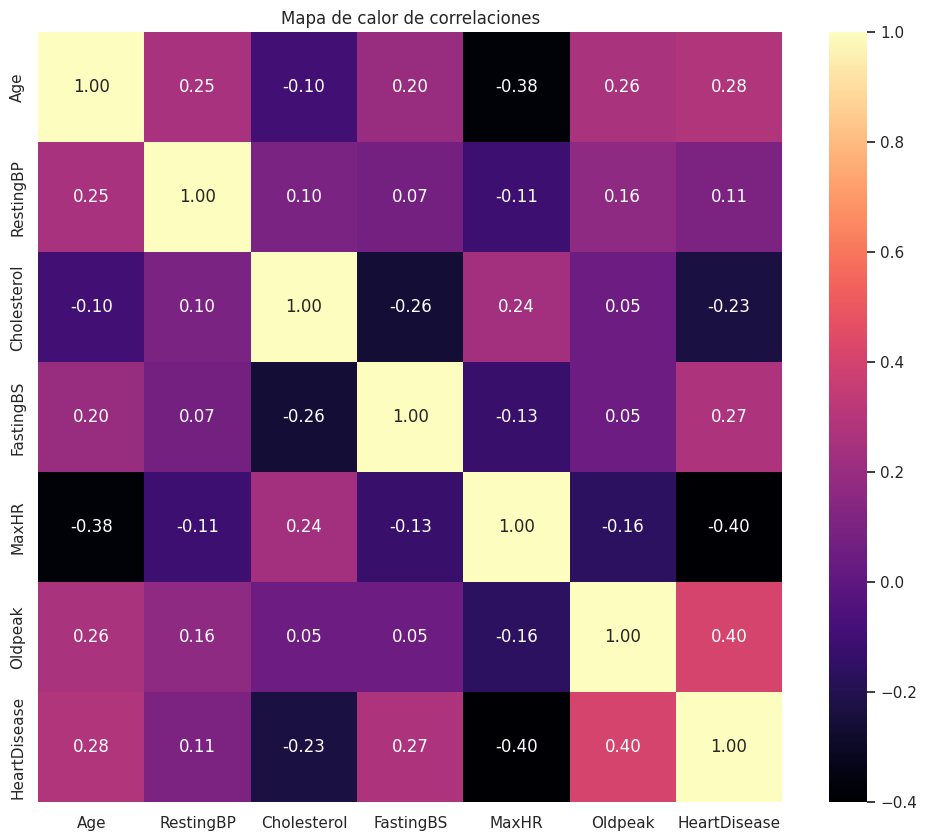

In [33]:
# Mapa de calor de correlaciones

sns.set_theme(style="whitegrid")

columnas_numericas = df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(12, 10))
sns.heatmap(
    df[columnas_numericas].corr(),
    annot=True,
    cmap="magma",
    fmt=".2f"
)

plt.title("Mapa de calor de correlaciones")
plt.savefig(ruta_guardado + 'matriz_confusion.png', dpi=1000, bbox_inches='tight') 
plt.show()

In [30]:
print(len(df.select_dtypes(include=["int64", "float64"]).columns))
print(len(df.select_dtypes(include=["object"]).columns))

columnas_objeto = df.select_dtypes(include=["object"]).columns

print("Columnas de tipo objeto:")
for col in columnas_objeto:
    print(col)

print("Columnas numericas:")
for col in columnas_numericas:   
    print(col)

df[["Sex", "HeartDisease"]].head(10)

7
5
Columnas de tipo objeto:
Sex
ChestPainType
RestingECG
ExerciseAngina
ST_Slope
Columnas numericas:
Age
RestingBP
Cholesterol
FastingBS
MaxHR
Oldpeak
HeartDisease


,Sex,HeartDisease
0,M,0
1,F,1
2,M,0
3,F,1
4,M,0
5,M,0
6,F,0
7,M,0
8,M,1
9,F,0


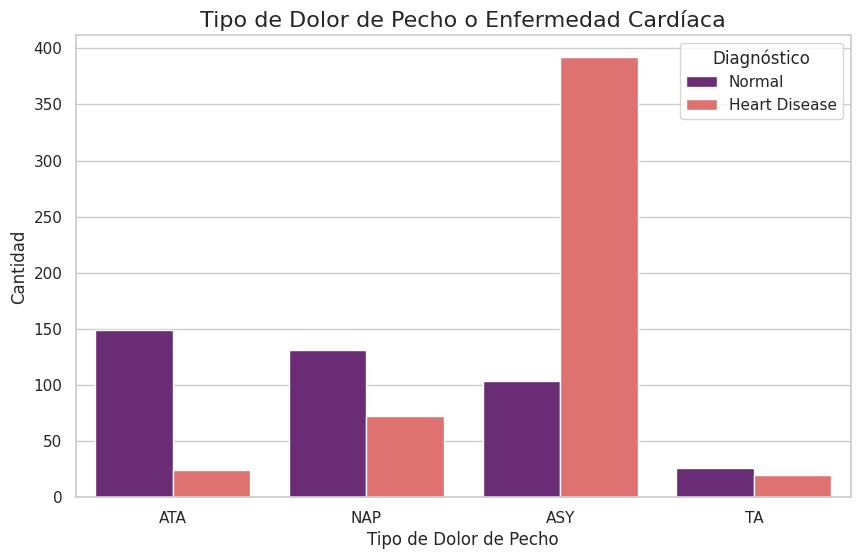

In [26]:
# Variable categorica vs target
# Tipo de dolor de pecho o enfermedad cardíaca

df_plot = df.copy()
df_plot["Diagnóstico"] = df_plot["HeartDisease"].map({0: "Normal", 1: "Heart Disease"})

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_plot,
    x="ChestPainType",
    hue="Diagnóstico",
    palette="magma"
)
plt.title("Tipo de Dolor de Pecho o Enfermedad Cardíaca", fontsize=16)
plt.xlabel('Tipo de Dolor de Pecho', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.savefig(ruta_guardado + 'tipo_dolor_pecho.png', dpi=1000, bbox_inches='tight') 
plt.show()


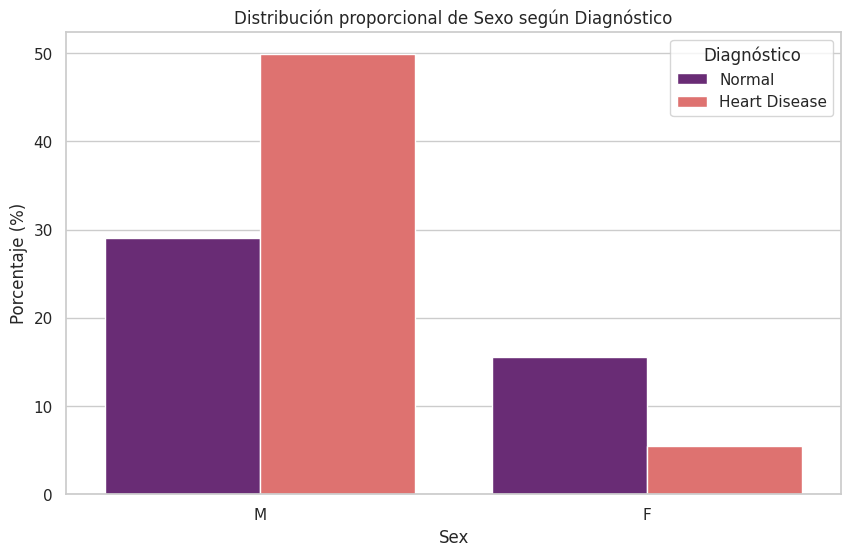

In [27]:
# Sexo vs Enfermedad Cardíaca proporcional

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_plot,
    x="Sex",
    hue="Diagnóstico",
    palette="magma",
    stat="percent"
)
plt.ylabel("Porcentaje (%)")
plt.title("Distribución proporcional de Sexo según Diagnóstico")
plt.savefig(ruta_guardado + 'distribution_sex.png', dpi=1000, bbox_inches='tight') 
plt.show()

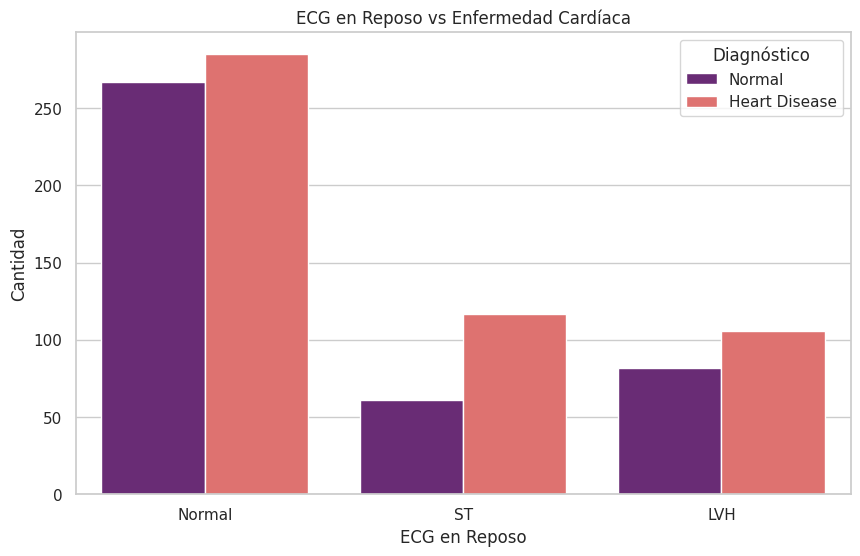

In [28]:
# ECG en Reposo o Enfermedad Cardíaca

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_plot, 
    x="RestingECG", 
    hue="Diagnóstico", 
    palette="magma"
)
plt.title("ECG en Reposo vs Enfermedad Cardíaca")
plt.xlabel("ECG en Reposo")
plt.ylabel("Cantidad")
plt.savefig(ruta_guardado + 'ECG.png', dpi=1000, bbox_inches='tight') 
plt.show()


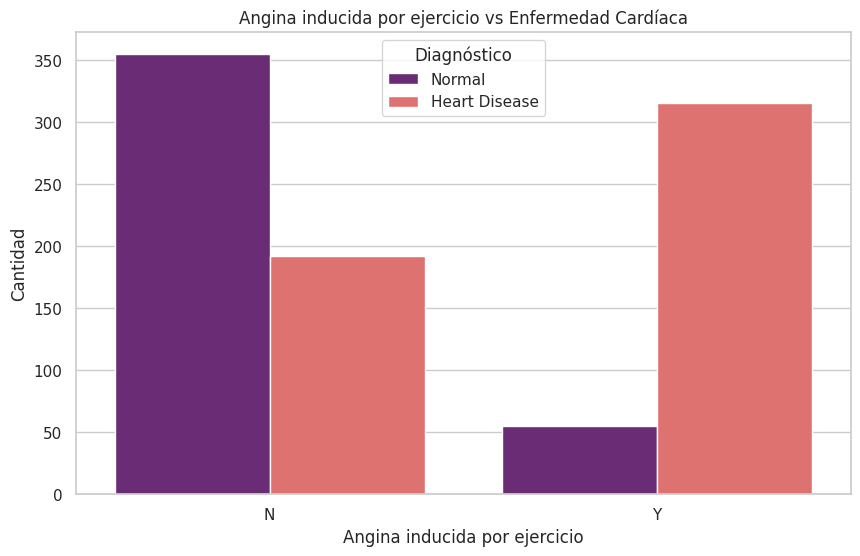

In [29]:
# Angina inducida por ejercicio o Enfermedad Cardíaca

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_plot, 
    x="ExerciseAngina", 
    hue="Diagnóstico", 
    palette="magma"
)
plt.title("Angina inducida por ejercicio vs Enfermedad Cardíaca")
plt.xlabel("Angina inducida por ejercicio")
plt.ylabel("Cantidad")
plt.savefig(ruta_guardado + 'angina.png', dpi=1000, bbox_inches='tight') 
plt.show()


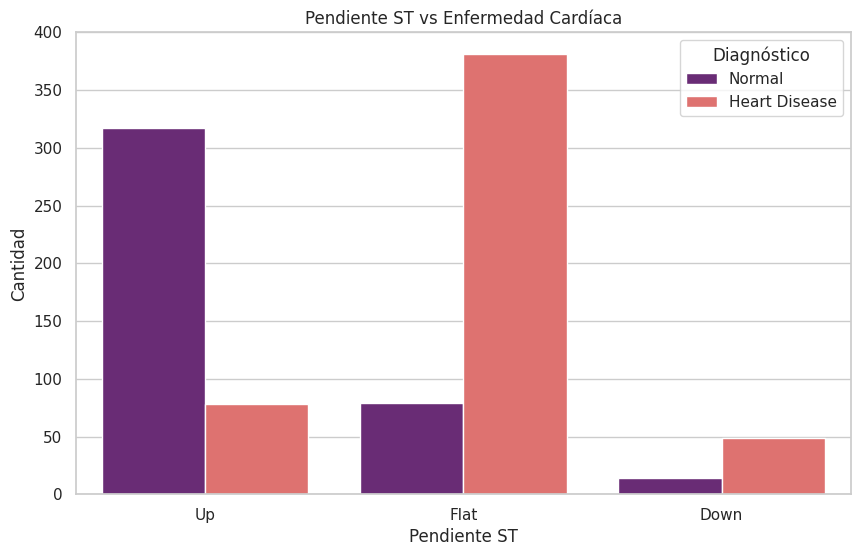

In [30]:
# ST pendiente o Enfermedad Cardíaca

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_plot, 
    x="ST_Slope", 
    hue="Diagnóstico", 
    palette="magma"
)
plt.title("Pendiente ST vs Enfermedad Cardíaca")
plt.xlabel("Pendiente ST")
plt.ylabel("Cantidad")
plt.savefig(ruta_guardado + 'pendiente_st.png', dpi=1000, bbox_inches='tight') 
plt.show()

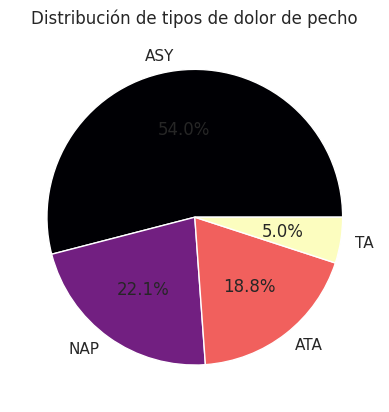

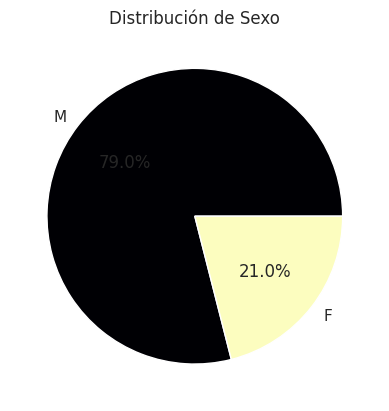

In [32]:
df['ChestPainType'].value_counts().plot.pie(autopct='%1.1f%%', colormap="magma")
plt.title("Distribución de tipos de dolor de pecho")
plt.ylabel("")
plt.savefig(ruta_guardado + 'distribution_dolor_pecho.png', dpi=1000, bbox_inches='tight') 
plt.show()


df["Sex"].value_counts().plot.pie(autopct='%1.1f%%', colormap="magma")
plt.title("Distribución de Sexo")
plt.ylabel("")
plt.savefig(ruta_guardado + 'distribution_sex_2.png', dpi=1000, bbox_inches='tight') 
plt.show()